In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [ ]:
!pip install libauc==1.2.0
from libauc.losses import AUCMLoss, CrossEntropyLoss
from libauc.optimizers import PESG, Adam
from libauc.models import densenet121 as DenseNet121
from libauc.datasets import CheXpert

import pandas as pd
import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, matthews_corrcoef
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### Reproducibility
def set_all_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 123
set_all_seeds(SEED)

In [ ]:
## Data Loading: Unzip files into Google notebook folder
%%time
!cp /content/gdrive/MyDrive/capstone/CheXpert-v1.0-small.zip /content/
!mkdir CheXpert
!unzip -q CheXpert-v1.0-small.zip -d /content/CheXpert/

CPU times: user 1.68 s, sys: 279 ms, total: 1.95 s
Wall time: 4min 20s


In [ ]:
### Data Loading: Training and test set
root = './CheXpert/CheXpert-v1.0-small/'
traindSet = CheXpert(csv_path=root+'train.csv', image_root_path=root, use_upsampling=False, use_frontal=True, image_size=224, mode='train', class_index=-1) # index: -1 denotes multi-label mode including 5 diseases
testSet = CheXpert(csv_path=root+'valid.csv',  image_root_path=root, use_upsampling=False, use_frontal=True, image_size=224, mode='valid', class_index=-1)
#expSet = CheXpert(csv_path=root+'cardiomegaly_test.csv',  image_root_path=root, use_upsampling=False, use_frontal=True, image_size=224, mode='valid', class_index=-1, verbose=False)
trainloader = torch.utils.data.DataLoader(traindSet, batch_size=32, num_workers=1, shuffle=True)
testloader = torch.utils.data.DataLoader(testSet, batch_size=32, num_workers=1, shuffle=False)
#exploader = torch.utils.data.DataLoader(expSet, batch_size=32, num_workers=1, shuffle=False)

Multi-label mode: True, Number of classes: [5]
------------------------------
Found 191027 images in total, 23385 positive images, 167642 negative images
Cardiomegaly(C0): imbalance ratio is 0.1224

Found 191027 images in total, 61493 positive images, 129534 negative images
Edema(C1): imbalance ratio is 0.3219

Found 191027 images in total, 12983 positive images, 178044 negative images
Consolidation(C2): imbalance ratio is 0.0680

Found 191027 images in total, 59583 positive images, 131444 negative images
Atelectasis(C3): imbalance ratio is 0.3119

Found 191027 images in total, 76899 positive images, 114128 negative images
Pleural Effusion(C4): imbalance ratio is 0.4026

Multi-label mode: True, Number of classes: [5]
------------------------------
Found 202 images in total, 66 positive images, 136 negative images
Cardiomegaly(C0): imbalance ratio is 0.3267

Found 202 images in total, 42 positive images, 160 negative images
Edema(C1): imbalance ratio is 0.2079

Found 202 images in total

In [ ]:
### Model: Load pre-trained model
model = DenseNet121(pretrained=True, last_activation='sigmoid', activations='relu', num_classes=5) # initialize model

# CPU
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/capstone/trained_auc_model.pt', map_location=torch.device('cpu'))) # load trained model

# GPU
model = model.cuda()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/capstone/trained_auc_model.pt')) # load trained model
model.eval();

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
def get_results(dataloader, num_batches = 6000):
    labels = []
    predictions = []

    for idx, data in enumerate(tqdm.tqdm(dataloader)):
      if idx == num_batches:
        break
      X, y = data
      X = X.cuda()
      y_pred = model(X)
    
      labels.append(y)
      predictions.append(y_pred.cpu().detach().numpy())
    
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    return labels, predictions

In [ ]:
y_train, y_train_pred_proba = get_results(trainloader, num_batches = 6000)
y_test, y_test_pred_proba = get_results(testloader)

100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


In [ ]:
y_train.shape, y_train_pred_proba.shape, y_test.shape, y_test_pred_proba.shape

((191027, 5), (191027, 5), (202, 5), (202, 5))

In [ ]:
diseases = {0: 'Cardiomegaly', 1: 'Edema', 2: 'Consolidation', 3: 'Atelectasis', 4: 'Pleural Effusion'}

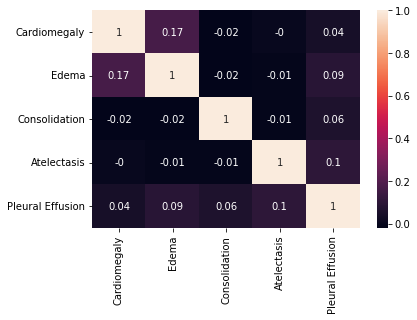

In [ ]:
y_true = pd.DataFrame(data = np.concatenate((y_train, y_test), axis = 0), columns = list(diseases.values()))
y_true.head()

df_corr_true = y_true.corr().round(2)

sns.heatmap(df_corr_true, annot = True)
plt.show()

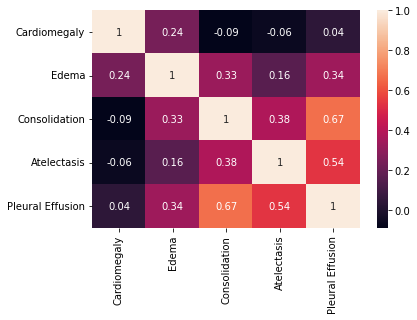

In [ ]:
diseases = {0: 'Cardiomegaly', 1: 'Edema', 2: 'Consolidation', 3: 'Atelectasis', 4: 'Pleural Effusion'}

y_pred_proba = pd.DataFrame(data = np.concatenate((y_train_pred_proba, y_test_pred_proba), axis = 0), columns = list(diseases.values()))
y_pred_proba.head()

df_corr_pred_proba = y_pred_proba.corr().round(2)

sns.heatmap(df_corr_pred_proba, annot = True)
plt.show()

In [ ]:
def get_binary_outcomes(predictions, best_thresholds):
    y_pred = np.zeros(predictions.shape)
    for idx in range(predictions.shape[1]):
      y_pred[:, idx] = (predictions[:, idx] >= best_thresholds[idx]).astype(int)

    return y_pred

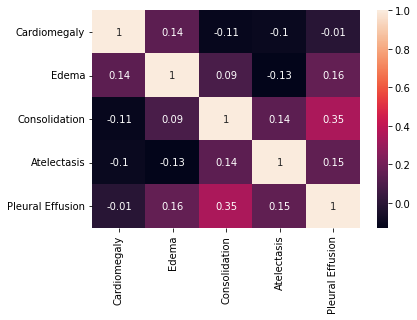

In [ ]:
y_pred_values = get_binary_outcomes(np.concatenate((y_train_pred_proba, y_test_pred_proba), axis = 0), best_thresholds)
y_pred = pd.DataFrame(data = y_pred_values, columns = list(diseases.values()))
y_pred.head()

df_corr_pred = y_pred.corr().round(2)

sns.heatmap(df_corr_pred, annot = True)
plt.show()

In [ ]:
confusion_matrix(y_true.iloc[:, 0], y_true.iloc[:, 1])

array([[118875,  48903],
       [ 10819,  12632]])

In [ ]:
y_true.iloc[:, 0].sum()

23451.0

In [ ]:
tp/(fn + tp)

0.5386550680141572

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true.iloc[:, 0], y_true.iloc[:, 1]).ravel()
num = tp*tn - fp*fn
denom = np.sqrt(tp + fp)*np.sqrt(tp + fn)*np.sqrt(tn + fp)*np.sqrt(tn + fn)
phi = num/denom
print(phi)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
matthews_corrcoef(y_true.iloc[:, 0], y_true.iloc[:, 1])

0.17355677100735176


0.17355677100735178

In [ ]:
def plot_ROC_curves(labels, predictions):
  fig, axs = plt.subplots(1, 5, figsize = (20, 5))
  axs = axs.ravel()
  for idx, disease in diseases.items():
    y_true = labels[:, idx]
    y_test_pred = predictions[:, idx]
    fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = y_test_pred)
    auc = roc_auc_score(y_true, y_test_pred)

    axs[idx].plot(fpr, tpr, color = "orange")
    axs[idx].plot([0, 1], [0, 1], color = "blue", linestyle = "--")
    axs[idx].set_xlabel("False Positive Rate")
    axs[idx].set_ylabel("True Positive Rate")
    axs[idx].set_title(f"{disease} with ROAUC = {auc:.2f}.")
  plt.tight_layout()

In [ ]:
def plot_PR_curves(labels, predictions):
  fig, axs = plt.subplots(1, 5, figsize = (20, 5))
  axs = axs.ravel()
  for idx, disease in diseases.items():
    y_true = labels[:, idx]
    y_test_pred = predictions[:, idx]
    precision, recall, thresholds = precision_recall_curve(y_true, y_test_pred)
    class_prevalence = len(y_true[y_true==1]) / len(y_true)

    axs[idx].plot([0, 1], [class_prevalence, class_prevalence], linestyle='--', label='No Skill') 
    axs[idx].plot(precision, recall, color = "orange")
    axs[idx].set_xlabel("Recall")
    axs[idx].set_ylabel("Precision")
    axs[idx].set_title(f"{disease}")
    plt.tight_layout()

In [ ]:
def fine_tune_threshold(labels, predictions, recall_level):
  best_thresholds = []
  for idx, disease in diseases.items():
    y_true = labels[:, idx]
    y_test_pred = predictions[:, idx]
    precision, recall, thresholds = precision_recall_curve(y_true, y_test_pred)

    n = len(recall)
    i = 0
    while i < n:
      i += 1
      if recall[i+1] <= recall_level:
        break
    best_thresholds.append(thresholds[i])
  return best_thresholds

In [ ]:
best_thresholds = fine_tune_threshold(y_train, y_train_pred_proba, recall_level = 0.5)
best_thresholds

[0.26384205, 0.7124037, 0.0836448, 0.39346296, 0.6536125]

In [ ]:
def evaluate(labels, predictions, best_thresholds):
  metrics_df = pd.DataFrame(columns=['Disease', 'Precision', 'Recall', 'F1 Score'])

  for idx, disease in diseases.items():
    y_true = labels[:, idx]
    y_pred = (predictions[:, idx] >= best_thresholds[idx]).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel()

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_score = 2*precision*recall/(precision + recall)

    metrics_df = pd.concat([metrics_df, pd.DataFrame(data=[[disease, precision, recall, f1_score]], columns=metrics_df.columns)])

  return metrics_df

In [ ]:
train_metrics_df = evaluate(y_train, y_train_pred_proba, best_thresholds)
train_metrics_df

,Disease,Precision,Recall,F1 Score
0,Cardiomegaly,0.554066,0.500021,0.525658
0,Edema,0.726433,0.500008,0.592319
0,Consolidation,0.149861,0.500039,0.230609
0,Atelectasis,0.489155,0.500008,0.494522
0,Pleural Effusion,0.841265,0.500007,0.627223


In [ ]:
test_metrics_df = evaluate(y_test, y_test_pred_proba, best_thresholds)
test_metrics_df

,Disease,Precision,Recall,F1 Score
0,Cardiomegaly,0.857143,0.181818,0.300000
0,Edema,0.785714,0.523810,0.628571
0,Consolidation,0.575758,0.593750,0.584615
0,Atelectasis,0.724638,0.666667,0.694444
0,Pleural Effusion,0.960000,0.375000,0.539326


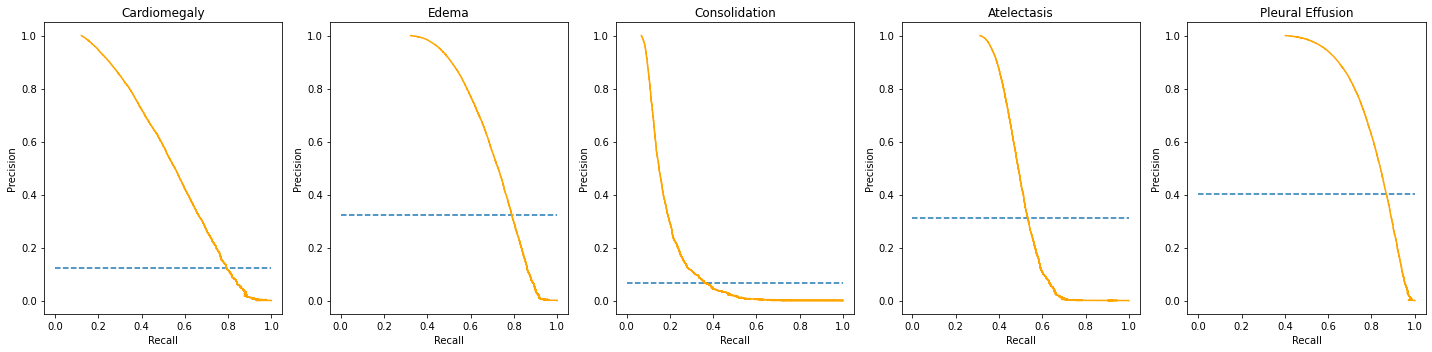

In [ ]:
plot_PR_curves(y_train, y_train_pred_proba)

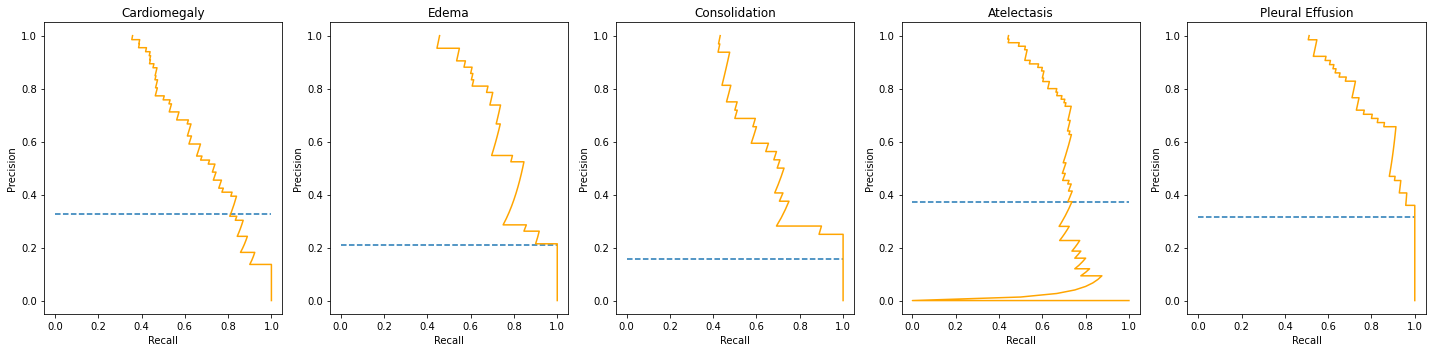

In [ ]:
plot_PR_curves(y_test, y_test_pred_proba)

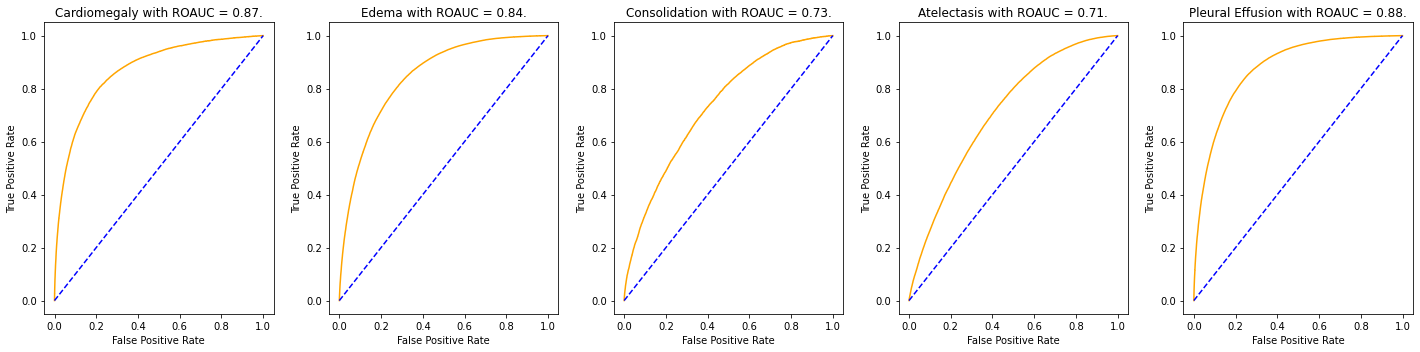

In [ ]:
plot_ROC_curves(y_train, y_train_pred_proba)

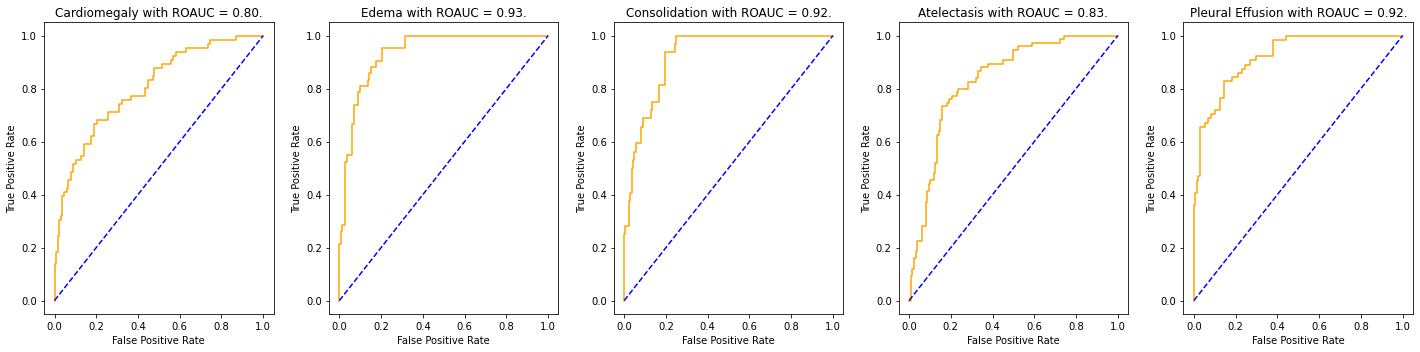

In [ ]:
plot_ROC_curves(y_test, y_test_pred_proba)

## Saliency Maps

In [ ]:
# https://pypi.org/project/grad-cam/
# https://www.kaggle.com/code/antwerp/where-is-the-model-looking-for-gradcam-pytorch/notebook

def show_saliency(index, method = 'GradCAM'):
  target_layers = [model.features[-1]]

  if method == 'GradCAM':
    cam = GradCAM(model=model, target_layers=target_layers)
  elif method == 'HiResCAM':
    cam = HiResCAM(model=model, target_layers=target_layers)
  elif method == 'GradCAMPlusPlus':
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

  for idx, data in enumerate(tqdm.tqdm(testloader)):
    X, y = data
    X = X.cuda()
    y_pred_proba = model(X)
    y_pred_proba = y_pred_proba.cpu().detach().numpy()
    y_pred = np.zeros(y_pred_proba.shape)
    for idx_dis, disease in diseases.items():
      y_pred[:, idx_dis] = (y_pred_proba[:, idx_dis] >= best_thresholds[idx_dis]).astype(int)

    grayscale_cam = cam(input_tensor=X)[index]
    print(grayscale_cam.max())
    
    rgb_img = X[index, :, :, :]
    rgb_img = rgb_img.permute(1, 2, 0)
    rgb_img = rgb_img.cpu().detach().numpy()
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    visualization = show_cam_on_image(img = rgb_img, mask = grayscale_cam, use_rgb=True)
    print(rgb_img.shape)

  Image.fromarray(visualization, 'RGB')
  
  return visualization, y[index], y_pred[index]

### GradCAM

 14%|█▍        | 1/7 [00:01<00:11,  1.95s/it]

0.9999999
(224, 224, 3)


 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]

0.9999999
(224, 224, 3)


 57%|█████▋    | 4/7 [00:03<00:02,  1.45it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:03<00:01,  1.61it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:04<00:00,  1.73it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

0.9999999
(224, 224, 3)
tensor([0., 0., 0., 0., 1.]) [0. 0. 1. 1. 1.]


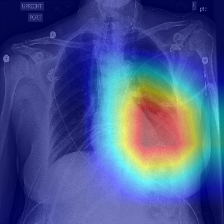

In [ ]:
visualization, y, y_pred = show_saliency(index = 3, method = 'GradCAM')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

 14%|█▍        | 1/7 [00:00<00:04,  1.38it/s]

0.9999999
(224, 224, 3)


 29%|██▊       | 2/7 [00:01<00:02,  1.68it/s]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:01<00:02,  1.82it/s]

0.0
(224, 224, 3)


 57%|█████▋    | 4/7 [00:02<00:01,  1.89it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:02<00:01,  1.94it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:03<00:00,  1.97it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

0.9999999
(224, 224, 3)
tensor([1., 1., 0., 0., 0.]) [0. 1. 0. 0. 0.]


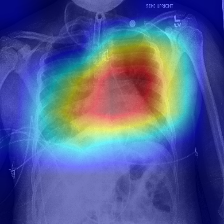

In [ ]:
visualization, y, y_pred = show_saliency(index = 4, method = 'GradCAM')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

### HiResCAM

 14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]

0.9999999
(224, 224, 3)


 29%|██▊       | 2/7 [00:01<00:02,  1.68it/s]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:01<00:02,  1.82it/s]

0.9999999
(224, 224, 3)


 57%|█████▋    | 4/7 [00:02<00:01,  1.90it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:02<00:01,  1.94it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:03<00:00,  1.97it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

0.9999999
(224, 224, 3)
tensor([0., 0., 0., 0., 1.]) [0. 0. 1. 1. 1.]


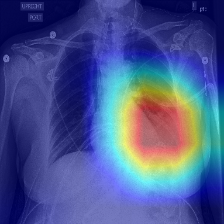

In [ ]:
visualization, y, y_pred = show_saliency(index = 3, method = 'HiResCAM')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

 14%|█▍        | 1/7 [00:00<00:04,  1.37it/s]

0.0
(224, 224, 3)


 29%|██▊       | 2/7 [00:01<00:02,  1.68it/s]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:01<00:02,  1.81it/s]

0.0
(224, 224, 3)


 57%|█████▋    | 4/7 [00:02<00:01,  1.88it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:02<00:01,  1.92it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:03<00:00,  1.96it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

0.9999999
(224, 224, 3)
tensor([1., 1., 0., 0., 0.]) [0. 1. 0. 0. 0.]


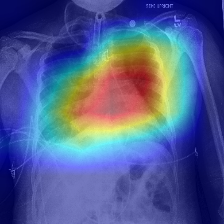

In [ ]:
visualization, y, y_pred = show_saliency(index = 4, method = 'HiResCAM')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

### GradCAMPlusPlus

 14%|█▍        | 1/7 [00:00<00:04,  1.36it/s]

0.9999999
(224, 224, 3)


 29%|██▊       | 2/7 [00:01<00:03,  1.66it/s]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:01<00:02,  1.80it/s]

0.9999999
(224, 224, 3)


 57%|█████▋    | 4/7 [00:02<00:01,  1.87it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:02<00:01,  1.92it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:03<00:00,  1.95it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

0.9999999
(224, 224, 3)
tensor([0., 0., 0., 0., 1.]) [0. 0. 1. 1. 1.]


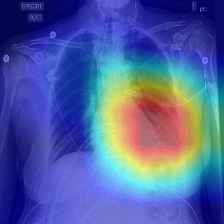

In [ ]:
visualization, y, y_pred = show_saliency(index = 3, method = 'GradCAMPlusPlus')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

 14%|█▍        | 1/7 [00:00<00:04,  1.39it/s]

0.9999999
(224, 224, 3)


 29%|██▊       | 2/7 [00:01<00:02,  1.69it/s]

0.9999999
(224, 224, 3)


 43%|████▎     | 3/7 [00:01<00:02,  1.81it/s]

0.9999999
(224, 224, 3)


 57%|█████▋    | 4/7 [00:02<00:01,  1.88it/s]

0.9999999
(224, 224, 3)


 71%|███████▏  | 5/7 [00:02<00:01,  1.92it/s]

0.9999999
(224, 224, 3)


 86%|████████▌ | 6/7 [00:03<00:00,  1.95it/s]

0.9999999
(224, 224, 3)


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

0.9999999
(224, 224, 3)
tensor([1., 1., 0., 0., 0.]) [0. 1. 0. 0. 0.]


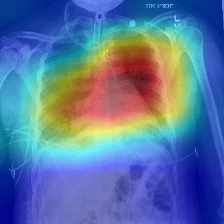

In [ ]:
visualization, y, y_pred = show_saliency(index = 4, method = 'GradCAMPlusPlus')
print(y, y_pred)
Image.fromarray(visualization, 'RGB')

In [ ]:
# https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

  0%|          | 0/5970 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])
tensor([0.0741, 0.2052, 0.4265], device='cuda:0')

 tensor([0.0073, 0.4386, 0.0096, 0.2379, 0.0164, 0.0251, 0.2511, 0.0096, 0.0289,
        0.1580, 0.0206, 0.0182, 0.0496, 0.0192, 0.0338, 0.1056, 0.0250, 0.0185,
        0.0438, 0.0552, 0.0124, 0.1005, 0.5183, 0.0163, 0.1434, 0.0347, 0.2343,
        0.0506, 0.4302, 0.0931, 0.0832, 0.0197], device='cuda:0',
       grad_fn=<SelectBackward0>)


  0%|          | 0/5970 [00:00<?, ?it/s]


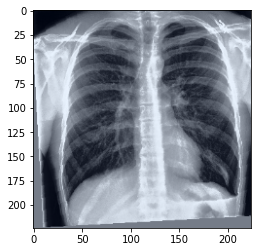

In [ ]:
def get_output(index):
  for idx, data in enumerate(tqdm.tqdm(trainloader)):
    X, y = data
    X = X.cuda()#[[index]]
    #y = y[[index]]
    img = X[0]
    print(X.shape)
    print(X[1, :, 0, 0])
    
    #print("\nlabels:", y.cpu().detach().numpy())
    y_pred = model(X)
    #print("pred:", y_pred.cpu().detach().numpy())
    print("\n", y_pred[:, 0])
    break

  img = img.permute(1, 2, 0)
  img = img.cpu().detach().numpy()
  gb_img = (img - np.min(img)) / (np.max(img) - np.min(img))
  plt.imshow(gb_img)
  plt.show()

get_output(12)
#get_output(1)
#get_output(2)
#get_output(3)
#get_output(4)